In [35]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.distributions.normal import Normal
import torchvision.utils as vutils

import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import time
import random

In [2]:
def set_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

In [3]:
set_seed(42)

In [24]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [25]:
transform = transforms.Compose([transforms.ToTensor()])

trainset = datasets.MNIST('.', download=True, train=True, transform=transform)
train_loader = DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.MNIST('.', download=True, train=False, transform=transform)
test_loader = DataLoader(testset, batch_size=64, shuffle=True)

In [26]:
def show_image(image, title='Sample Image'):
  plt.figure(figsize=(1, 1))
  plt.imshow(image.permute(1, 2, 0).cpu().numpy().repeat(3, 2))
  plt.title(title)
  plt.axis('off')
  plt.show()

def show_images_grid(images, title='Sample Images Grid'):
  plt.figure(figsize=(7, 7))
  grid = vutils.make_grid(images, nrow=images.shape[0]//2, padding=2, normalize=True)
  plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
  plt.title(title)
  plt.axis('off')
  plt.show()

In [28]:
class Encoder(nn.Module):
    def __init__(self, im_chan=1, output_chan=32, hidden_dim=16):
        super(Encoder, self).__init__()
        self.z_dim = output_chan

        self.encoder = nn.Sequential(
            self.init_conv_block(im_chan, hidden_dim),
            self.init_conv_block(hidden_dim, hidden_dim * 2),
            self.init_conv_block(hidden_dim * 2, output_chan * 2, final_layer=True),
        )

    def init_conv_block(self, input_channels, output_channels, kernel_size=4, stride=2, padding=0, final_layer=False):
        layers = [
            nn.Conv2d(input_channels, output_channels,
                          kernel_size=kernel_size,
                          padding=padding,
                          stride=stride)
        ]
        if not final_layer:
            layers += [
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True)
            ]
        return nn.Sequential(*layers)

    def forward(self, image):
        encoder_pred = self.encoder(image)
        encoding = encoder_pred.view(len(encoder_pred), -1)
        mean = encoding[:, :self.z_dim]
        logvar = encoding[:, self.z_dim:]
        return mean, torch.exp(logvar*0.5)

In [29]:
class Decoder(nn.Module):
    def __init__(self, z_dim=32, im_chan=1, hidden_dim=64):
        super(Decoder, self).__init__()
        self.z_dim = z_dim
        self.decoder = nn.Sequential(
            self.init_conv_block(z_dim, hidden_dim * 4),
            self.init_conv_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.init_conv_block(hidden_dim * 2, hidden_dim),
            self.init_conv_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def init_conv_block(self, input_channels, output_channels, kernel_size=3, stride=2, padding=0, final_layer=False):
        layers = [
            nn.ConvTranspose2d(input_channels, output_channels,
                               kernel_size=kernel_size,
                               stride=stride, padding=padding)
        ]
        if not final_layer:
            layers += [
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True)
            ]
        else:
            layers += [nn.Sigmoid()]
        return nn.Sequential(*layers)

    def forward(self, z):
        x = z.view(-1, self.z_dim, 1, 1)
        return self.decoder(x)

In [30]:
class VAE(nn.Module):
  def __init__(self, z_dim=32, im_chan=1):
    super(VAE, self).__init__()
    self.z_dim = z_dim
    self.encoder = Encoder(im_chan, z_dim)
    self.decoder = Decoder(z_dim, im_chan)

  def forward(self, images):
    z_dist = Normal(*self.encoder(images))
    z = z_dist.rsample()
    decoding = self.decoder(z)
    return decoding, z_dist

In [44]:
from torch.distributions.kl import kl_divergence
def kl_divergence_loss(z_dist, dist):
    return kl_divergence(z_dist, dist).sum(-1).sum()

reconstruction_loss = nn.BCELoss(reduction='sum')

In [40]:
def train_model(epochs=10, z_dim = 16, beta=1, mean=0.0, stddev=1.0):
  model = VAE(z_dim=z_dim).to(device)
  model_opt = torch.optim.Adam(model.parameters())
  for epoch in tqdm(range(epochs), desc="Epoch"):
      epoch_loss = []
      for images, step in tqdm(train_loader, desc="Batch", leave=False):
          images = images.to(device)
          model_opt.zero_grad()
          recon_images, encoding = model(images)
          dist = Normal(torch.full_like(encoding.mean, mean), torch.full_like(encoding.stddev, stddev))
          loss = reconstruction_loss(recon_images, images) + beta * kl_divergence_loss(encoding, dist)
          loss.backward()
          epoch_loss.append(loss.item())
          model_opt.step()
  return model

In [42]:
def posterior_sampling(model, data_loader, n_samples=25):
  model.eval()
  images, _ = next(iter(data_loader))
  images = images[:n_samples]
  with torch.no_grad():
    _, encoding_dist = model(images.to(device))
    input_sample=encoding_dist.sample()
    recon_images = model.decoder(input_sample)
    show_images_grid(images, title=f'input samples')
    show_images_grid(recon_images, title=f'generated posterior samples')

In [43]:
def prior_sampling(model, z_dim=32, n_samples = 25):
  model.eval()
  input_sample=torch.randn(n_samples, z_dim).to(device)
  with torch.no_grad():
    sampled_images = model.decoder(input_sample)
  show_images_grid(sampled_images, title=f'generated prior samples')

In [ ]:
small_normal_vae = train_model(epochs=25, z_dim=2)

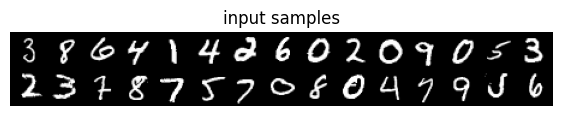

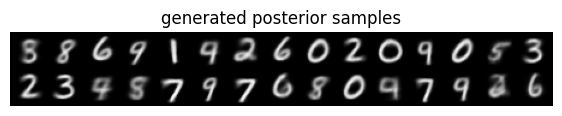

In [66]:
posterior_sampling(small_normal_vae, train_loader, n_samples=30)

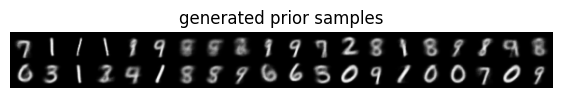

In [67]:
prior_sampling(small_normal_vae, 2, n_samples=40)

In [ ]:
small_gaussian_vae = train_model(epochs=25, z_dim=2, mean=1.0, stddev=2.0)

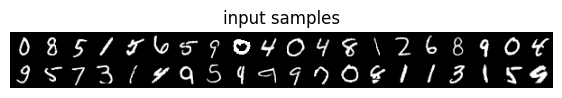

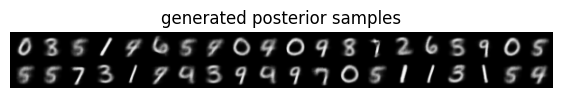

In [74]:
posterior_sampling(small_gaussian_vae, train_loader, n_samples=30)

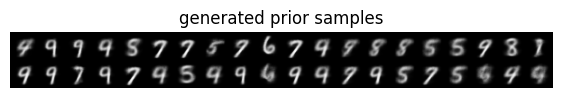

In [70]:
prior_sampling(small_gaussian_vae, 2, n_samples=40)

In [ ]:
small_gaussian_beta_vae = train_model(epochs=25, z_dim=2, beta=4.0, mean=1.0, stddev=2.0)

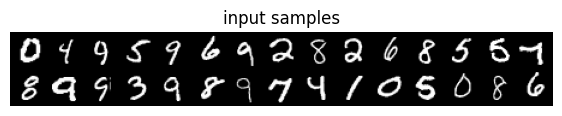

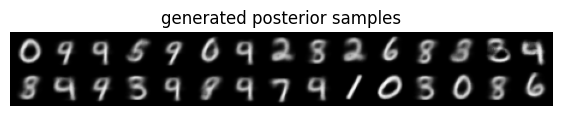

In [72]:
posterior_sampling(small_gaussian_beta_vae, train_loader, n_samples=30)

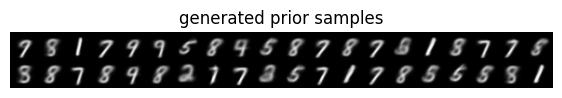

In [73]:
prior_sampling(small_gaussian_beta_vae, 2, n_samples=40)

In [ ]:
normal_vae = train_model(epochs=25, z_dim=16)

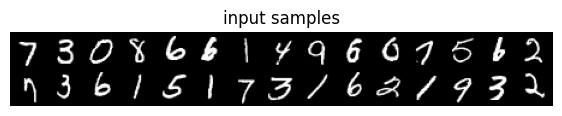

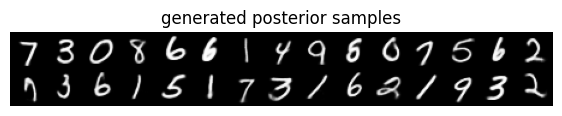

In [51]:
posterior_sampling(normal_vae, train_loader, n_samples=30)

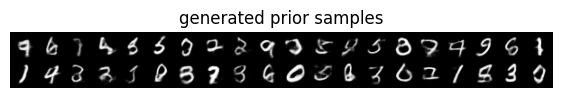

In [64]:
prior_sampling(normal_vae, 16, n_samples=40)

In [ ]:
gaussian_vae = train_model(epochs=25, z_dim=16, mean=1.0, stddev=2.0)

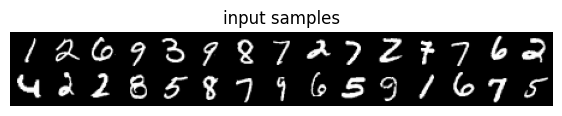

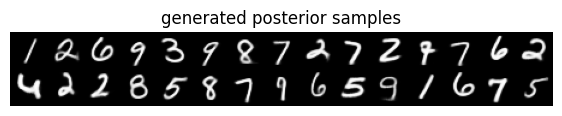

In [54]:
posterior_sampling(gaussian_vae, train_loader, n_samples=30)

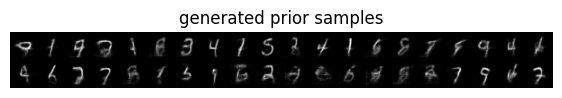

In [63]:
prior_sampling(gaussian_vae, 16, n_samples=40)

In [ ]:
gaussian_beta_vae = train_model(epochs=25, z_dim=16, beta=4.0, mean=1.0, stddev=2.0)

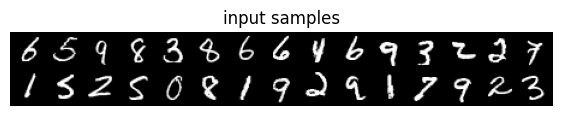

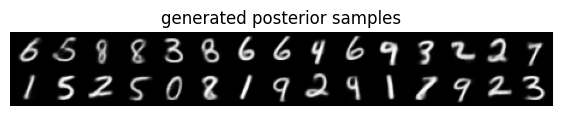

In [61]:
posterior_sampling(gaussian_beta_vae, train_loader, n_samples=30)

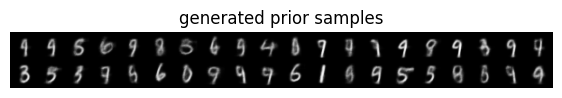

In [62]:
prior_sampling(gaussian_beta_vae, 16, n_samples=40)